In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import matplotlib.ticker as ticker
import geopandas as gpd
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.dates as mdates
from shapely.geometry.point import Point
import seaborn as sns
%matplotlib inline

# personal imports
from plot_utils import add_nice_xaxis, draw_black_identity_line
from PrISM_P20 import calculate_inverse_api_ts

## PrISM - Study with insitu SM and Precipitation - Algerri Balaguer

### AB3 insitu: we have SM but no direct data on Precipitation
A solution is to use the meteo station of meteocat, here we find the closest to AB3:

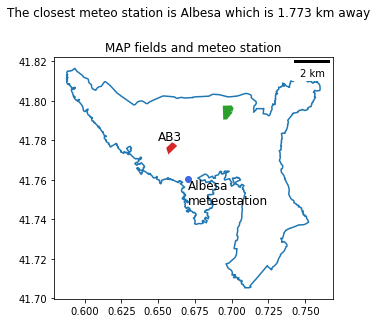

In [3]:
meteocat_stations_file = Path('/data/PhDGiovanni/Code_Linux_Desktop/CODEs/3-Irrigation_data_study/XEMA_meteostations.geojson')
meteocat_stations = gpd.read_file(meteocat_stations_file)

algbal_shape = gpd.read_file("/data/PhDGiovanni/5.IrriEst/DATA/INSITU/AlgerriBalaguer/SHAPEFILE/Algerri-Balaguer_irrigated.geojson")
ab3_shape = gpd.read_file("/data/PhDGiovanni/5.IrriEst/DATA/INSITU/6_albesa/SHAPEFILES/6Albesa.geojson")
castello_shape = gpd.read_file("/data/PhDGiovanni/5.IrriEst/DATA/INSITU/7_castello/SHAPEFILES/7Castello.geojson")

distances = meteocat_stations.distance(ab3_shape.geometry[0])
station_name = meteocat_stations.loc[distances.argmin()].names

fig, ax = plt.subplots(figsize = (5,5))
ax = algbal_shape.to_crs('EPSG:4236').boundary.plot(ax=ax)
ax = ab3_shape.to_crs('EPSG:4236').plot(ax =ax, color = 'tab:red')
ax = castello_shape.to_crs('EPSG:4236').plot(ax =ax, color = 'tab:green')

points = gpd.GeoSeries([Point(0, 41.78), Point(1, 41.78)], crs=4326)  # Geographic WGS 84 - degrees
points = points.to_crs(25831) # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])
ax.add_artist(ScaleBar(distance_meters))
plt.annotate('AB3', (0.65,41.78), fontsize = 12)
meteocat_stations.loc[[distances.argmin()]].to_crs('EPSG:4236').plot(ax=ax, color = 'RoyalBlue')
plt.annotate('Albesa\nmeteostation', (0.67, 41.748), fontsize = 12)
ax.set_title('MAP fields and meteo station')
tx = fig.suptitle(f'The closest meteo station is {station_name} which is {distances.min()/1000:.03f} km away')

#### ALBESA (AB3)

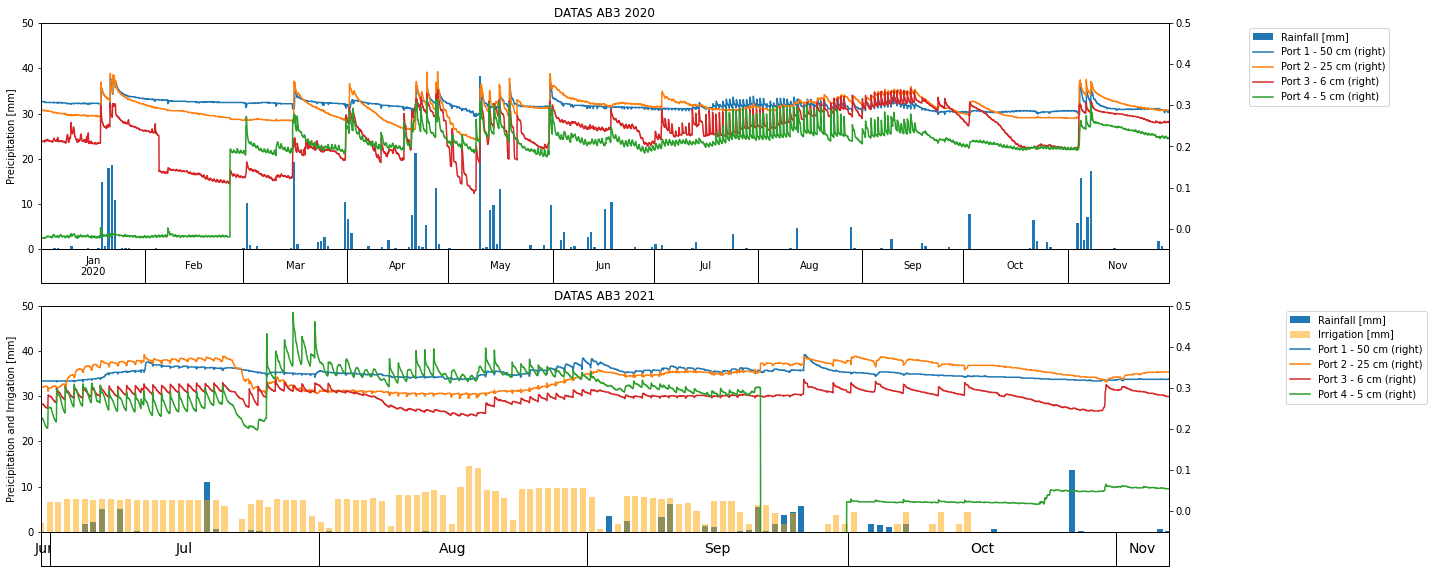

In [26]:
ab32020_file     = Path("/data/PhDGiovanni/5.IrriEst/DATA/INSITU/6_albesa/RAW_DATA/Liase2021_AlgerriBalaguer/AB3_2020.xlsx")
ab32020 = pd.read_excel(ab32020_file, index_col = 0, header = [0,1], skiprows=[1])
ab32021_file     = Path("/data/PhDGiovanni/5.IrriEst/DATA/INSITU/6_albesa/RAW_DATA/Liase2021_AlgerriBalaguer/AB3_2021.xlsx")
out_ab32021_file = Path("/data/PhDGiovanni/5.IrriEst/DATA/INSITU/6_albesa/RAW_DATA/Liase2021_AlgerriBalaguer/created/AB3_2021.csv")
ab32021 = pd.read_excel(ab32021_file, index_col = 0, header = [0,1], skiprows=[1])
ab3_irr_2021_file = '/home/gpaolini/5.IrriEST/DATA/INSITU/6_albesa/RAW_DATA/irrigation_albesa_castello_2021.xlsx'
ab3_irr_2021 = pd.read_excel(ab3_irr_2021_file,sheet_name=1, index_col = 0, parse_dates=True).iloc[:,[1]]
colors=['tab:blue', 'tab:orange', 'tab:red', 'tab:green']
########## PLOT ########################################
fig, axs = plt.subplots(2,1, figsize = (20,8))
#2020
ax = ab32020.iloc[:,[7]].resample('1D').sum().plot.bar(y = ab32020.columns[7], ax=axs[0], width = 0.7,
                                                       label = 'Rainfall [mm]')
val0 = mdates.date2num(pd.Timestamp(ax.get_xticklabels()[0].get_text()) + pd.Timedelta('12H'))
sm = ab32020.iloc[:,[0,1,2,4]].copy()
sm.columns = [f"{f[0][:-1]} {f[0][-1]} - {f[1]}" for f in sm.columns]
sm = sm.rename(columns = {col:'Port 4 - 5 cm' for col in sm.columns if '4' in col})
col_to_plot = sm.columns
sm['ind'] = [mdates.date2num(dd)-val0  for dd in sm.index]
ax2 = sm.plot(ax=ax, x='ind', y = col_to_plot, color = colors, secondary_y = True)
add_nice_xaxis(ax)
lgnd = ax.get_legend()
lgnd.set_bbox_to_anchor((1.2,1))
ax.set_ylim(0,50)
ax2.set_ylim(-0.05,0.5)
ax.set_ylabel('Preicipitation [mm]')
ax.set_title('DATAS AB3 2020')

#2021
ax = ab32021.iloc[:,[6]].resample('1D').sum().plot.bar(y = ab32021.columns[6], ax=axs[1], width = 0.7, 
                                                       label = 'Rainfall [mm]')
ab3_irr_2021.plot.bar(ax=ax, color = 'orange', y = ab3_irr_2021.columns[0], width = 0.7, 
                      label = 'Irrigation [mm]', alpha = 0.5)
val0 = mdates.date2num(pd.Timestamp(ax.get_xticklabels()[0].get_text()) + pd.Timedelta('12H'))
sm = ab32021.iloc[:,[0,1,2,4]].copy()
sm.columns = [f"{f[0][:-1]} {f[0][-1]} - {f[1].split('(')[1].split(')')[0]}" for f in sm.columns]
col_to_plot = sm.columns
sm['ind'] = [mdates.date2num(dd)-val0  for dd in sm.index]
ax2 = sm.plot(ax=ax, x='ind', y = col_to_plot, color = colors, secondary_y = True)
add_nice_xaxis(ax, fontsize=14)
lgnd = ax.get_legend()
lgnd.set_bbox_to_anchor((1.1,1))
ax.set_ylim(0,50)
ax2.set_ylim(-0.05,0.5)
ax.set_ylabel('Preicipitation and Irrigation [mm]')
ax.set_title('DATAS AB3 2021')
fig.tight_layout()

#### ALBESA (AB3) with Lysimeters

Text(0.5, 1.0, 'DATAS LYS AB3 2021')

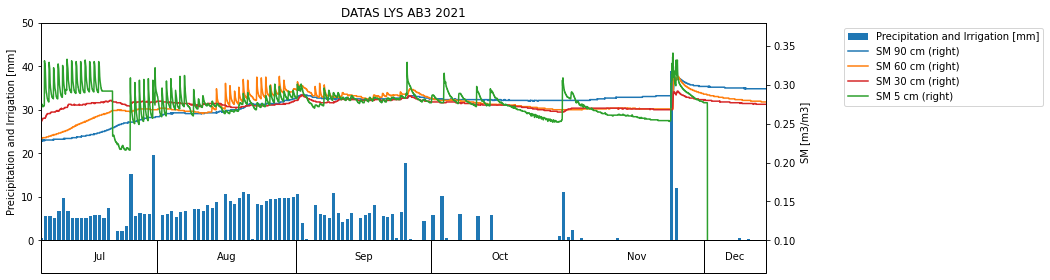

In [27]:
lys1_ab32021_file = Path("/data/PhDGiovanni/5.IrriEst/DATA/INSITU/6_albesa/RAW_DATA/Liase2021_AlgerriBalaguer/LYS_1.xlsx")
lys1_ab32021 = pd.read_excel(lys1_ab32021_file, sheet_name='DATA', index_col = 0, header = [0,1], skiprows=[0])
lys_data = lys1_ab32021.iloc[:,[0,3,4,5]].copy()
lys_data.columns = ['SM 90 cm','SM 60 cm','SM 30 cm','SM 5 cm']

precirr_data = lys1_ab32021.iloc[:,[10]].copy()

########## PLOT ########################################
fig, ax = plt.subplots(figsize = (13,4))
ax = precirr_data.resample('1D').sum().plot.bar(y = precirr_data.columns[0], ax=ax, width = 0.7,
                                                       label = 'Precipitation and Irrigation [mm]')
val0 = mdates.date2num(pd.Timestamp(ax.get_xticklabels()[0].get_text()) + pd.Timedelta('12H'))
col_to_plot = lys_data.columns
lys_data['ind'] = [mdates.date2num(dd)-val0  for dd in lys_data.index]
ax2 = lys_data.plot(ax=ax, x='ind', y = col_to_plot, color = colors, secondary_y = True)
add_nice_xaxis(ax)
lgnd = ax.get_legend()
lgnd.set_bbox_to_anchor((1.1,1))
ax.set_ylim(0,50)
ax.set_ylabel('Preicipitation and Irrigation [mm]')
ax2.set_ylim(0.1,0.38)
ax2.set_ylabel('SM [m3/m3]')
ax.set_title('DATAS LYS AB3 2021')

## Comparison between:
1. Precipitation+Irrigation data: in-situ instrument VS meteo-station+pumps data
2. Sm data: sensors VS Lysimeters

In [6]:
#### 1. Precipitation+Irrigation
# add irrigation from pumps and precipitation from albesa meteo station together
albesa_precirr = ab32021.iloc[:,[6]].resample('1D').sum()
albesa_precirr.columns = ['meteo prec+pumps irr']
ab3_irr_2021.columns = ['meteo prec+pumps irr']
albesa_precirr = (albesa_precirr + ab3_irr_2021).dropna()
precirr_data.columns = ['insitu Prec+Irr']
# ###### Comparison Prec+Irr from meteo station and pumps vs insitu
comparison = pd.merge(precirr_data.resample('D').sum(), albesa_precirr, 
                      right_index= True, left_index= True).dropna()
# ########## PLOT ########################################

# # barplot of Time-series
# ax = comparison.plot.bar(figsize = (15,4), color = ['tab:green', 'tab:red'], width = 0.9)
# # plot of Time-series
# # val0 = mdates.date2num(pd.Timestamp(ax.get_xticklabels()[0].get_text()) + pd.Timedelta('12H'))
# # comp['ind'] = [mdates.date2num(dd)-val0  for dd in comp.index]
# # ax2 = comp.plot(x = 'ind',y = ['lysimeter (5cm)', 'sensor (6cm)'],
# #                 ax=ax, color = ['tab:green', 'tab:red'], secondary_y = True)
# # ax2.set_ylim(0, 36)
# # lgnd = ax.get_legend()
# # lgnd.set_bbox_to_anchor((1.25,1))
# add_nice_xaxis(ax)

# # correlation
# axg = sns.jointplot(x='insitu Prec+Irr', y='meteo prec+pumps irr', data=comparison, 
#                     kind="reg", truncate=False,
#                     height=4, color = 'tab:purple')
# axj = draw_black_identity_line(axg.ax_joint)
# axj.xaxis.label.set_color('tab:green')
# axj.yaxis.label.set_color('tab:red')

PROBLEM: Prec+IRR daat looks quite different. Which one to trust? probably the insitu data since they follow better the SM time-series of the lysimeter

In [7]:
#### 2. Soil Moisture
comp = pd.merge(lys_data[['SM 5 cm']],sm[['Port 3 - 6 cm']], right_index= True, left_index= True).dropna()*100
comp = comp.loc['20210706':'20211130']
comp.columns = ['lysimeter (5cm)','sensor (6cm)']
# # plot of Time-series
# ax = comp.plot(figsize = (13,3), color = ['tab:green', 'tab:red'])
# ax.set_title('Soil Moisture comparison')
# # correlation
# axg2 = sns.jointplot(x='lysimeter (5cm)', y='sensor (6cm)', data=comp.resample('D').mean(),
#               kind="reg", truncate=False,
#               height=4, color = 'tab:purple') 
# axj2 = draw_black_identity_line(axg2.ax_joint)
# axj2.xaxis.label.set_color('tab:green')
# axj2.yaxis.label.set_color('tab:red')

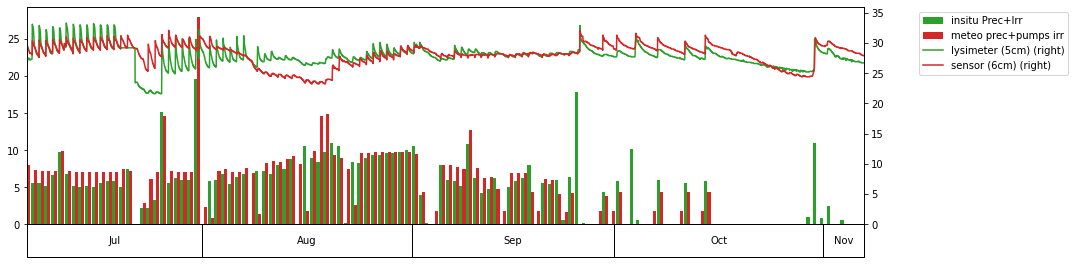

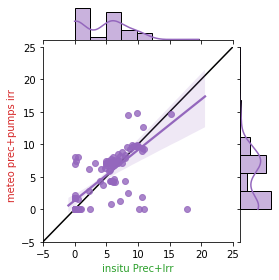

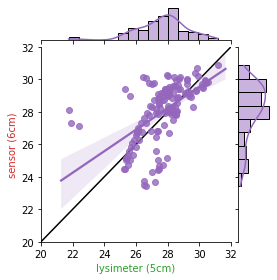

In [30]:
#### plot everything together
# add irrigation from pumps and precipitation from albesa meteo station together
albesa_precirr = ab32021.iloc[:,[6]].resample('1D').sum()
albesa_precirr.columns = ['meteo prec+pumps irr']
ab3_irr_2021.columns = ['meteo prec+pumps irr']
albesa_precirr = (albesa_precirr + ab3_irr_2021).dropna()


########## PLOT ########################################

###### Comparison Prec+Irr from meteo station and pumps vs insitu
precirr_data.columns = ['insitu Prec+Irr']
comparison = pd.merge(precirr_data.resample('D').sum(), albesa_precirr, 
                      right_index= True, left_index= True).dropna()

# barplot of Time-series
ax = comparison.plot.bar(figsize = (15,4), color = ['tab:green', 'tab:red'], width = 0.9)
# plot of Time-series
val0 = mdates.date2num(pd.Timestamp(ax.get_xticklabels()[0].get_text()) + pd.Timedelta('12H'))
comp['ind'] = [mdates.date2num(dd)-val0  for dd in comp.index]
ax2 = comp.plot(x = 'ind',y = ['lysimeter (5cm)', 'sensor (6cm)'],
                ax=ax, color = ['tab:green', 'tab:red'], secondary_y = True)
add_nice_xaxis(ax)
ax2.set_ylim(0, 36)
lgnd = ax.get_legend()
lgnd.set_bbox_to_anchor((1.25,1))

# correlation Prec+Irr
axg = sns.jointplot(x='insitu Prec+Irr', y='meteo prec+pumps irr', data=comparison, 
                    kind="reg", truncate=False,
                    height=4, color = 'tab:purple')
axj = draw_black_identity_line(axg.ax_joint)
axj.xaxis.label.set_color('tab:green')
axj.yaxis.label.set_color('tab:red')

# correlation
axg2 = sns.jointplot(x='lysimeter (5cm)', y='sensor (6cm)', data=comp.resample('D').mean(),
              kind="reg", truncate=False,
              height=4, color = 'tab:purple') 
axj2 = draw_black_identity_line(axg2.ax_joint)
axj2.xaxis.label.set_color('tab:green')
axj2.yaxis.label.set_color('tab:red')